In [1]:
import numpy as np
from utils import load_object
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
# path = '/home/taghianj/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph'
# path = '/home/mehran/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph'
path = '/home/mehran/Documents/SAC_GCN/Data/FetchReach-v2/graph'

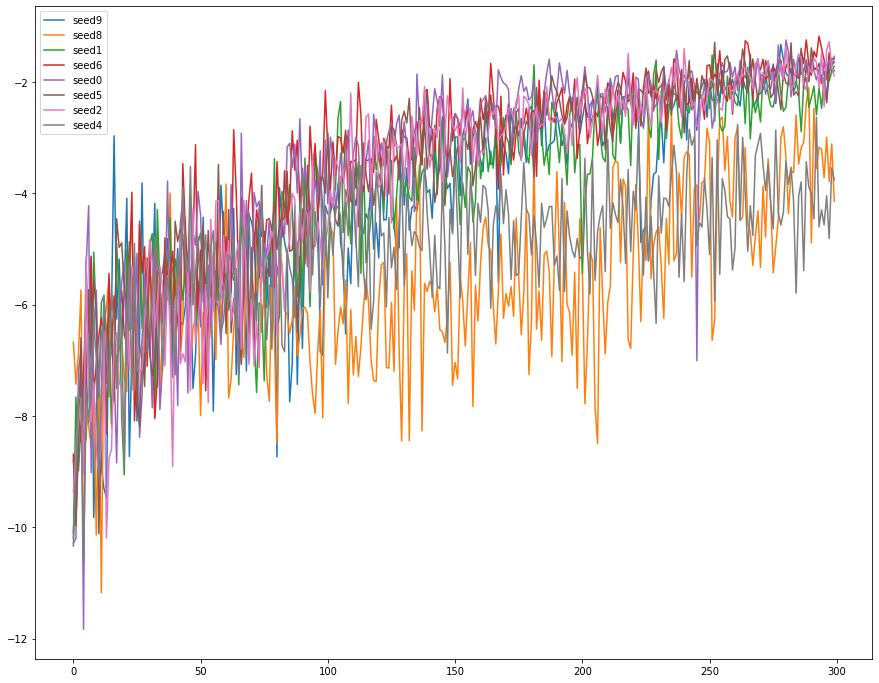

In [14]:
plt.figure(figsize=[15,12])
seeds = os.listdir(path)
seeds = [s for s in seeds if os.path.isdir(os.path.join(path, s))]

for s in seeds:
    data = load_object(f'{path}/{s}/eval.pkl')[:, 3]
    plt.plot(data, label=f'{s}')

plt.legend()

In [12]:
import pickle, gzip
# file_path = "/home/taghianj/Documents/SAC_GCN/Data/cedar/Walker2d-v2/graph/seed0/buffer.pkl"
for seed in range(12):
    file_path = f"/home/taghianj/Documents/SAC_GCN/Data/beluga/HalfCheetah-v2/graph/seed{seed}/buffer.pkl"
    try:
        buffer = None
        with open(file_path, 'rb') as f:
            p = pickle.Unpickler(f)
            buffer = p.load()
    except EOFError:
        print(seed)

5
6
7


In [1]:
from Graph_SAC.replay_memory import ReplayMemory

In [9]:
len(buffer)

1000000

In [2]:
rm = ReplayMemory(1000000, 0)

In [3]:
# rm.load_buffer("/home/taghianj/Documents/SAC_GCN/Data/buffer.pkl")
rm.load_buffer("/home/taghianj/Documents/SAC_GCN/Data/cedar/Walker2d-v2/graph/seed0/buffer.pkl")

EOFError: Ran out of input

In [16]:
len(buffer)

1000000

In [10]:
data = pd.read_csv("/home/mehran/Documents/SAC_GCN/Data/Hopper-v2/thigh_joint/seed2/eval.csv")

In [11]:
data

,num_episodes,num_steps,num_updates,eval_reward
0,9.0,194.0,0.0,121.254049
1,19.0,432.0,175.0,109.890246
2,29.0,641.0,384.0,68.919956
3,39.0,898.0,641.0,46.692771
4,49.0,1130.0,873.0,45.844892
...,...,...,...,...
995,9959.0,1776840.0,1776583.0,721.098825
996,9969.0,1778792.0,1778535.0,691.768661
997,9979.0,1780701.0,1780444.0,718.182107
998,9989.0,1782675.0,1782418.0,681.614950


In [27]:
from threading import Thread
import pickle, pickletools, gzip
import time

def save_object(obj, path):
    with gzip.open(path, "wb") as f:
        pickled = pickle.dumps(obj)
        optimized_pickle = pickletools.optimize(pickled)
        f.write(optimized_pickle)

def load_object(path):
    with gzip.open(path, 'rb') as f:
        p = pickle.Unpickler(f)
        obj = p.load()
    return obj

class Buffer:
    def __init__(self):
        self.thread = None
        self.obj = None
        
    def save_obj(self, path):
        if self.thread is not None:
            self.thread.join()
        self.thread = Thread(target=save_object, args=(self.obj.copy(), path))
        self.thread.start()

In [40]:
import numpy as np

a = np.arange(1000000).reshape([1000,1000])
bf = Buffer()
bf.obj = a
bf.save_obj('test.pkl')
# b = np.arange(10000).reshape([100, 100])
# bf.obj = b
# bf.save_obj('test.pkl')

In [42]:
c1 = load_object('test.pkl')

In [37]:
c2 = load_object('test2.pkl')

In [43]:
c1

array([[     0,      1,      2, ...,    997,    998,    999],
       [  1000,   1001,   1002, ...,   1997,   1998,   1999],
       [  2000,   2001,   2002, ...,   2997,   2998,   2999],
       ...,
       [997000, 997001, 997002, ..., 997997, 997998, 997999],
       [998000, 998001, 998002, ..., 998997, 998998, 998999],
       [999000, 999001, 999002, ..., 999997, 999998, 999999]])

In [2]:
'shoulder_pan_joint'.split('_')[:-1]

['shoulder', 'pan']

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
plt.cm.inferno(np.linspace(0, 1, 10))

array([[1.46200e-03, 4.66000e-04, 1.38660e-02, 1.00000e+00],
       [1.04551e-01, 4.70080e-02, 2.53430e-01, 1.00000e+00],
       [2.90763e-01, 4.56440e-02, 4.18637e-01, 1.00000e+00],
       [4.72328e-01, 1.10547e-01, 4.28334e-01, 1.00000e+00],
       [6.46260e-01, 1.73914e-01, 3.78359e-01, 1.00000e+00],
       [8.12239e-01, 2.66786e-01, 2.74661e-01, 1.00000e+00],
       [9.29644e-01, 4.11479e-01, 1.45367e-01, 1.00000e+00],
       [9.85315e-01, 6.08422e-01, 2.42020e-02, 1.00000e+00],
       [9.69783e-01, 8.20825e-01, 2.38686e-01, 1.00000e+00],
       [9.88362e-01, 9.98364e-01, 6.44924e-01, 1.00000e+00]])